### 필요한 라이브러리 다운로드 및 임포트

In [1]:
#%pip install -U git+https://github.com/albumentations-team/albumentations
#%pip install opencv-python
#%pip install seaborn
#%pip install pandas
#%pip install matplotlib
#%pip install tqdm
#%pip install plotly
#%pip install tensorflow
#%pip install pydot
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow
print("Current tensorflow version == {}".format(tensorflow.__version__))

Current tensorflow version == 2.7.0


In [3]:
import os
import random
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tqdm
import cv2

from warnings import filterwarnings
filterwarnings("ignore")

In [4]:
## import tensorflow and keras 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

#from mlxtend.plotting imp ort plot_confusion_matrix

## import sklearn metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

In [5]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

### 데이터세트 로딩 및 살펴보기 Load Dataset and Exploration 

In [6]:
# 이미지 디렉토리 검색
img_dir = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray'
print(os.listdir(img_dir))

['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [7]:
## 폴더를 직접 지정하는 방법 (1) 
train_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train'
val_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/val'
test_folder = 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/test'

In [8]:
## 각 이미지 경로들을 glob라이브러리와 와일드카드를 이용해 리스트화 (2)
train_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train/**/*.jpeg")
val_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/val/**/*.jpeg")
test_list = glob.glob("C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/test/**/*.jpeg")
print(train_list[:2])
print(val_list[:2])
test_list[:2] 

['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train\\NORMAL\\IM-0115-0001.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train\\NORMAL\\IM-0117-0001.jpeg']
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/val\\NORMAL\\NORMAL2-IM-1430-0001.jpeg']


['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/test\\NORMAL\\IM-0001-0001.jpeg',
 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/test\\NORMAL\\IM-0003-0001.jpeg']

In [9]:
print("The number of the training dataset is {}".format(len(train_list)))
print("The number of the validation dataset is {}".format(len(val_list)))
print("The number of the test dataset is {}".format(len(test_list)))

The number of the training dataset is 5216
The number of the validation dataset is 16
The number of the test dataset is 624


In [10]:
# 노멀 이미지와 폐렴이미지 리스트 만들기 
normal_list = []
pneumonia_list = []

for i in ["train", "test", "val"]:
    path = os.path.join(img_dir, i)
    normal = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    normal_list.extend(normal)
    pneumonia = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    pneumonia_list.extend(pneumonia)
    
print("The number of the normal lung dataset is {}".format(len(normal_list)))
print("The number of the pneumonia dataset is {}".format(len(pneumonia_list)))
    

The number of the normal lung dataset is 1583
The number of the pneumonia dataset is 4273


#### 학습 및 벨리데이션 데이터 세트 재생성
- 밸리데이션 세트의 이미지가 16개로 너무 적은 느낌이 있습니다. 따라서, 학습 데이터와 벨리데이션 세트를 합친후, 다시 train_test_split 으로 나누겠습니다. 

In [11]:
## 학습데이터와 벨리데이션 데이터 합친후, 나누기
train_val_list = train_list + val_list
print(len(train_val_list))
print(5216+16)

train_files, val_files = train_test_split(train_val_list, test_size=0.2)
print(len(train_files))
print(len(val_files))

5232
5232
4185
1047


In [12]:
# 새로운 학습 리스트 파일명과 벨리데이션 리스트 파일명 확인
print(train_files[0:2])
print(val_files[0:2])

['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train\\PNEUMONIA\\person634_bacteria_2525.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train\\PNEUMONIA\\person500_bacteria_2107.jpeg']
['C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train\\PNEUMONIA\\person1235_virus_2095.jpeg', 'C:/Users/sunny/Documents/MASTER/DeepLearning/x-ray-image/chest_xray/train\\PNEUMONIA\\person932_virus_1593.jpeg']


In [26]:
# 카운터 변수를 설정하여, 학습 이미지와 벨리데이션 이미지의 노멀이미지와 폐렴이미지를 카운트
train_normal_count = 0
train_pneumonia_count = 0

for file in train_files:
    if "NORMAL" in file: 
        train_normal_count +=1
    else:
        train_pneumonia_count +=1

val_normal_count = 0
val_pneumonia_count = 0

for file in val_files:
    if "NORMAL" in file: 
        val_normal_count +=1
    else:
        val_pneumonia_count +=1


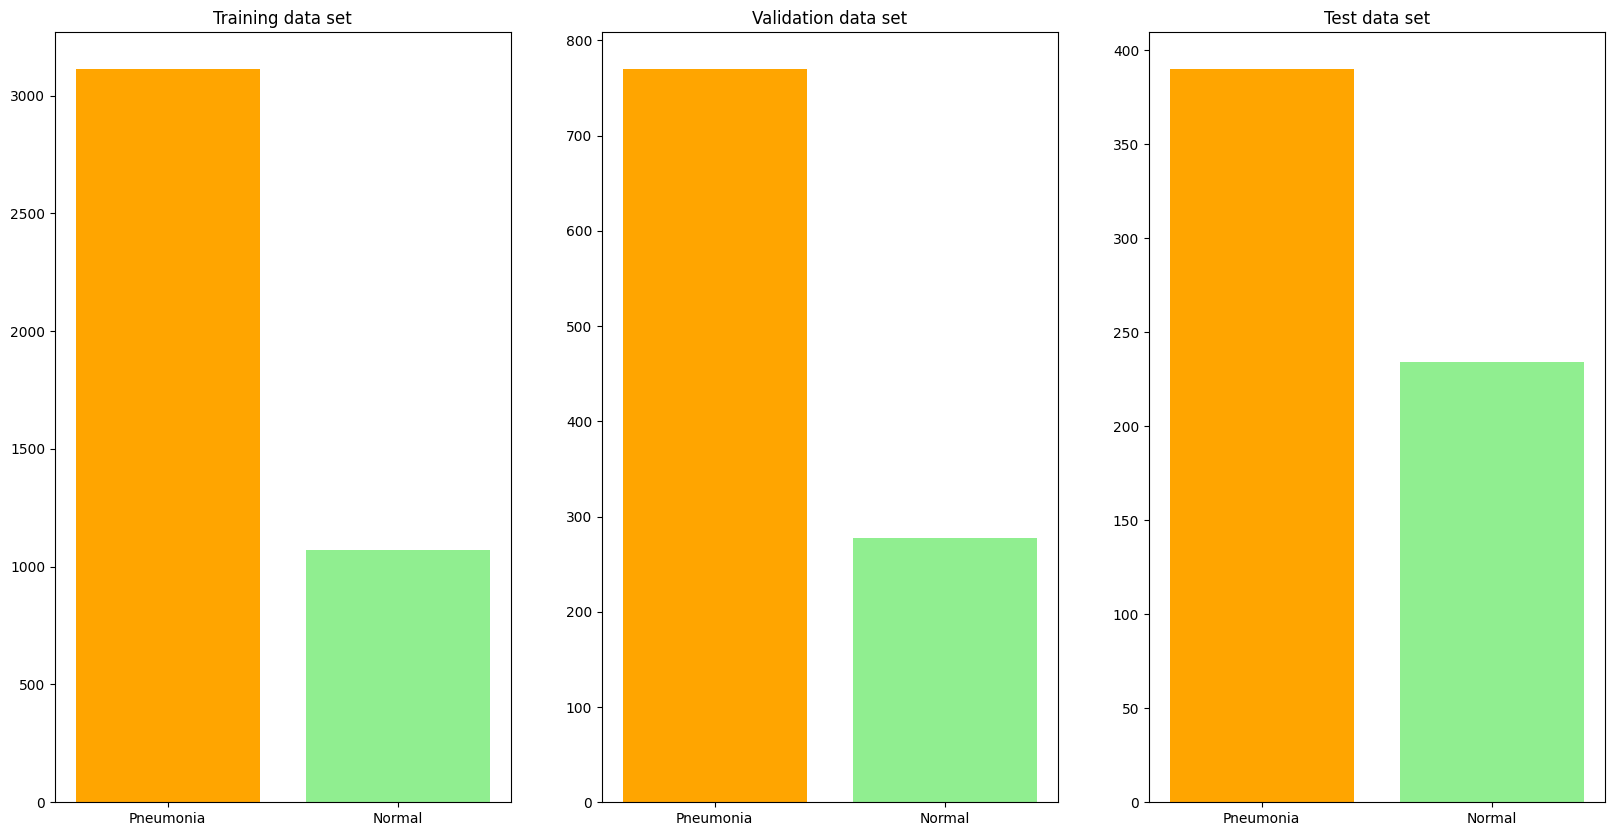

In [27]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.bar(x=["Pneumonia", "Normal"], 
        height=[train_pneumonia_count, train_normal_count], 
        color=["orange", "lightgreen"])
plt.title("Training data set")

plt.subplot(1, 3, 2)
plt.bar(x=["Pneumonia", "Normal"], 
        height=[val_pneumonia_count, val_normal_count], 
        color=["orange", "lightgreen"])
plt.title("Validation data set")

plt.subplot (1 , 3 , 3)
plt.bar (x = ["Pneumonia","Normal"] ,
         height = (len (os.listdir (test_folder + "/PNEUMONIA")) , 
                    len (os.listdir (test_folder + "/NORMAL"))
                   ) , 
         color = ["orange", "lightgreen"])
plt.title ("Test data set")

plt.show()

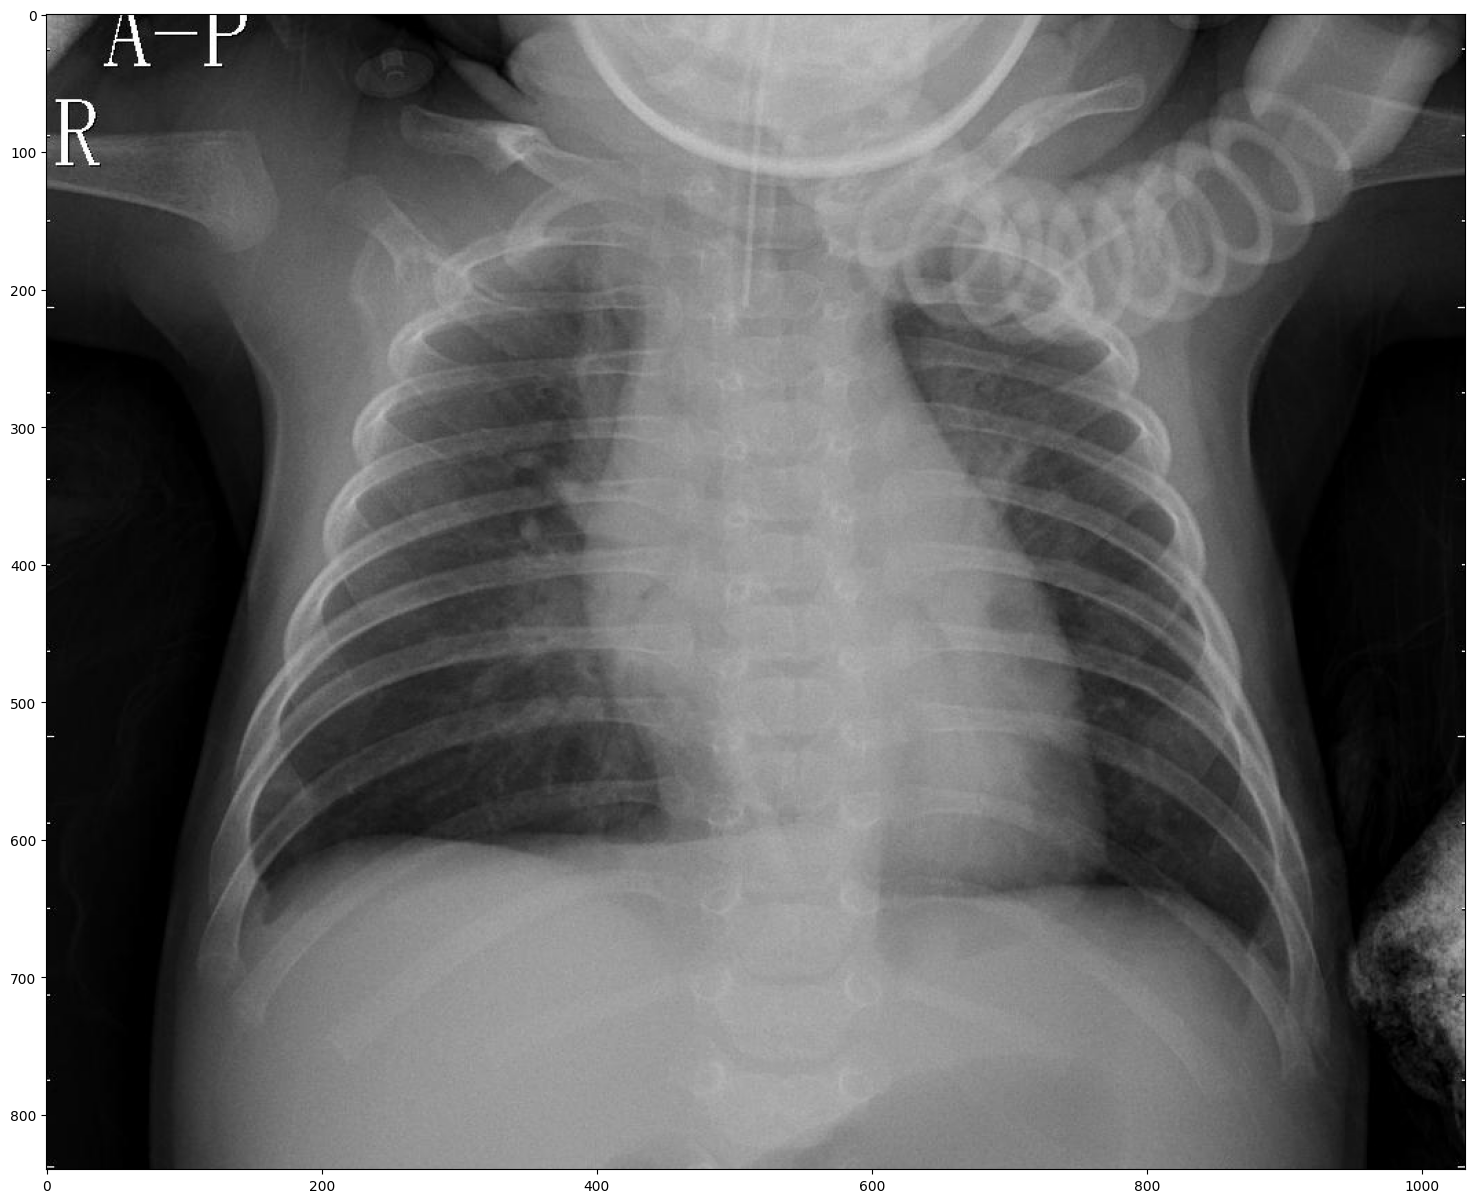

In [15]:
# 폐렴 샘플이미지 시각화
fig = plt.figure(figsize = (20, 15))
plt.imshow(load_img(random.choice(pneumonia_list)))
plt.show()

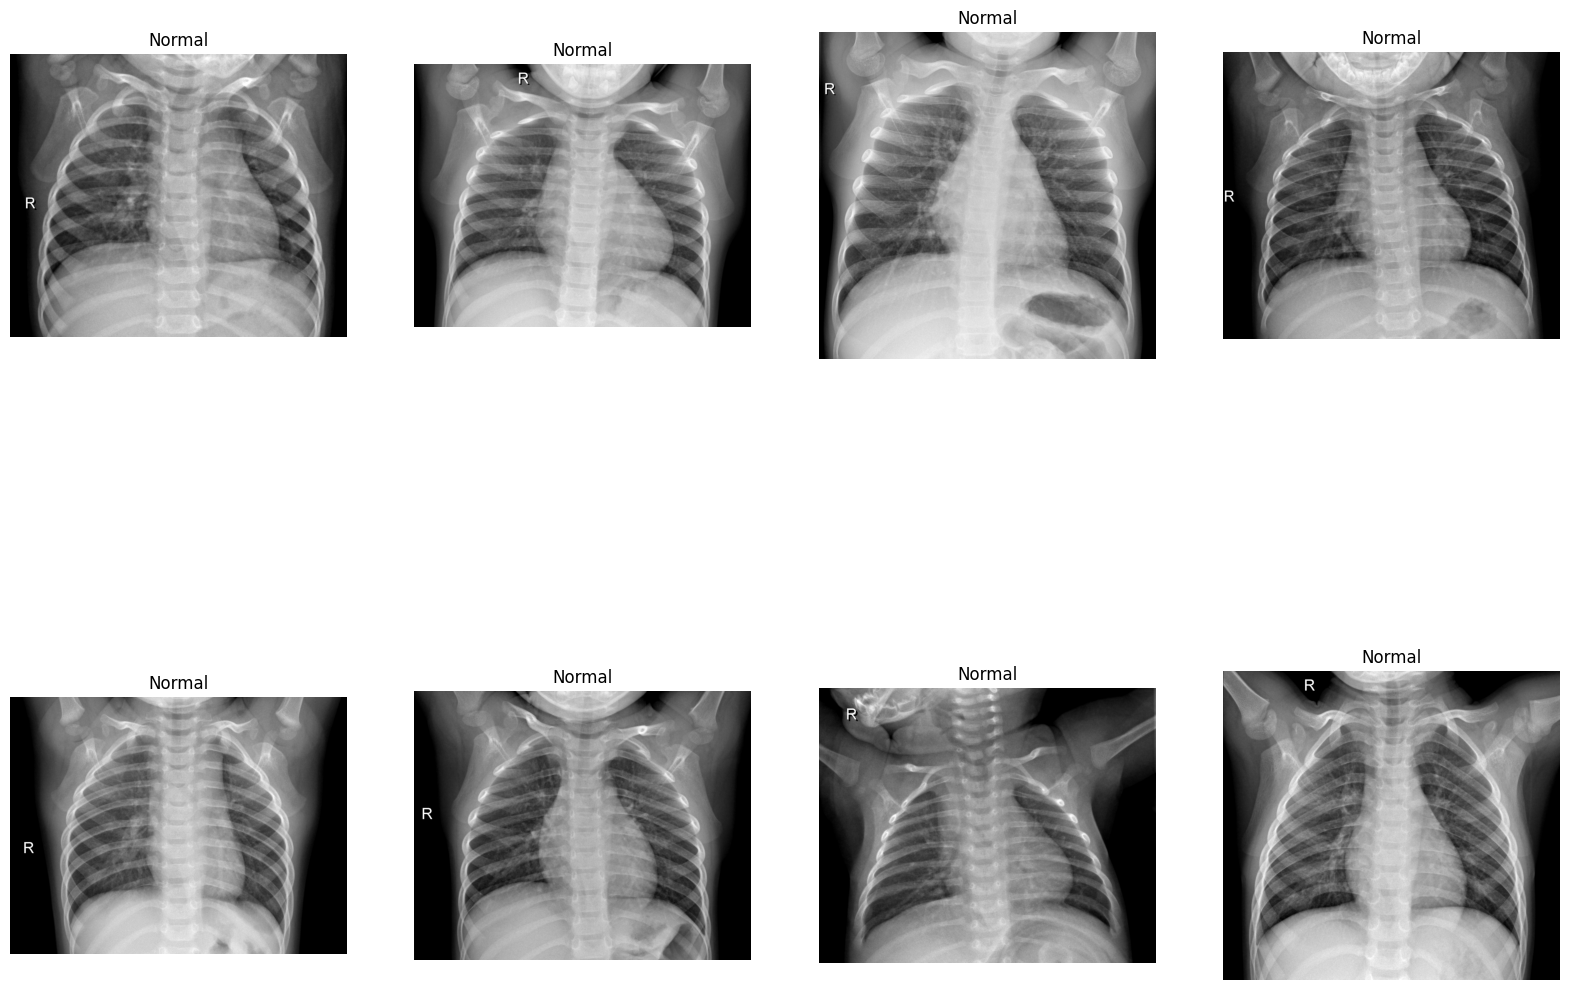

In [16]:
# 여러장의 건강한 폐 샘플이미지 시각화
fig = plt.figure(figsize = (20, 15))
columns, rows = 4, 2
for i in range(1,9):
    img = cv2.imread(random.choice(normal_list))
    fig.add_subplot(rows, columns, i)
    plt.title('Normal')
    plt.axis('off')
    plt.imshow(img)
   

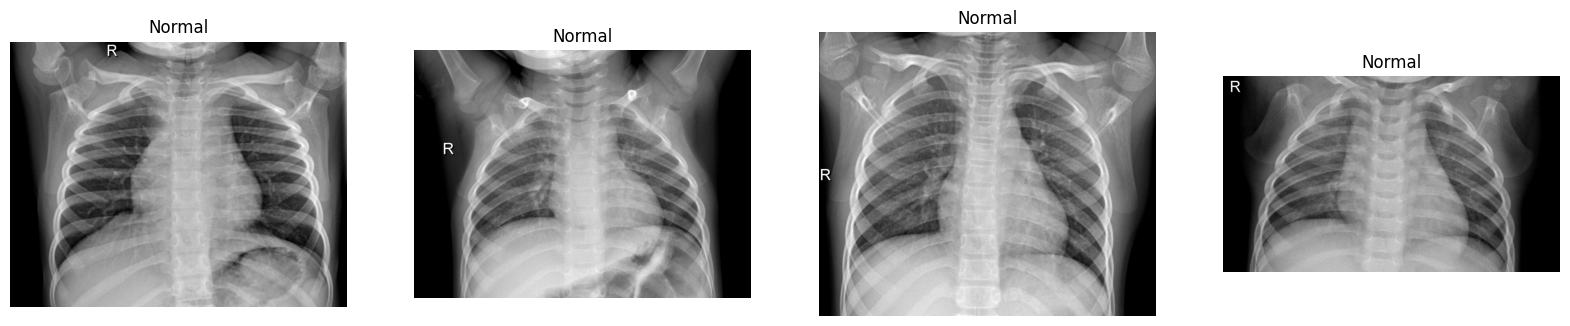

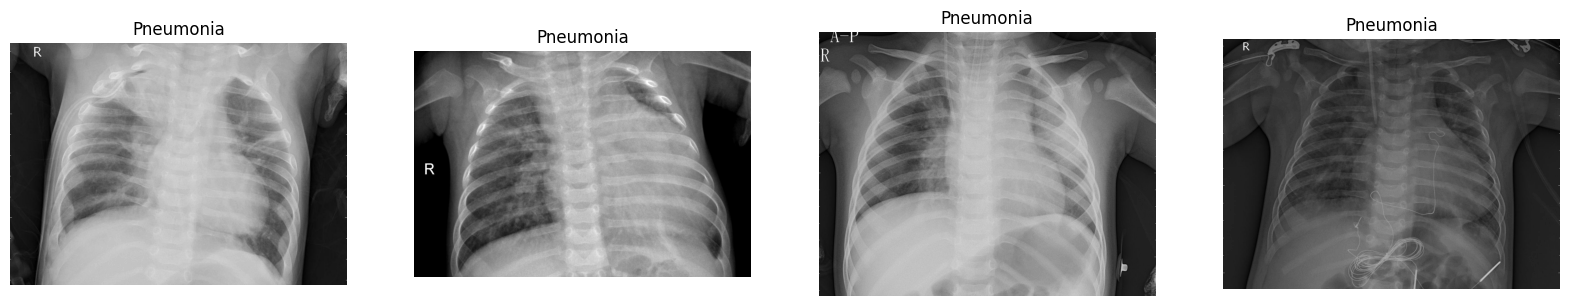

In [17]:
# 여러장의 건강한 폐 샘플이미지와 폐렴 샘플 이미지를 시각화
num_samples = 4
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,10))
for i in range(num_samples):
    img_path = random.choice(normal_list)
    img = mpimg.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('Normal')
    axes[i].axis('off')

# Visualize some pneumonia images
fig, axes = plt.subplots(nrows=1, ncols=num_samples, figsize=(20,10))
for i in range(num_samples):
    img_path = random.choice(pneumonia_list)
    img = mpimg.imread(img_path)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title('Pneumonia')
    axes[i].axis('off')

###  전처리 및 배치 데이터세트 생성 Data Augmentation and Batch Dataset Generation
- X-ray 이미지를 스캔시 항상 특정한 포지션을 취한 뒤 환자를 촬영하고, 결과물 이미지도 같으므로 데이터 이미지 증식을 따로 할 필요가 없다고 생각됩니다. 따라서, 이미지를 플립하거나, 로테이션 하는 등의 전처리는 진행하지 않는것이 처음의 플랜이었습니다. 
- 하지만 위의 바 그래프에서 보여지듯이, 폐렴 이미지의 숫자가 건강한 폐 이미지 보다 많습니다. 이는 데이터의 class imabalnce를 의미하므로, 모델이 편향되게 학습될 수 있음을 의미합니다. 
- 클래스의 데이터 양을 비슷하게 만들기 위해 전처리를 진행하였습니다
<br><br>
- DataGenerator는 일반적으로 전체 데이터 세트를 메모리에 맞출 수 없는 경우 Keras 모델을 학습하기 위한 데이터 일괄 처리를 생성하는 데 사용됩니다. 이미지 데이터의 양이 많으므로, DataGenerator를 사용하겠습니다. 

In [18]:
import albumentations as A
from torch.utils.data import Dataset

class AlbumentationsDataset(Dataset):
    def __init__(self, file_list, batch_size=32, shuffle=True, augmentation=True):
        self.file_list = file_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
    
        self.aug = A.Compose([
            A.Resize(512,512), #
            A.RandomCrop(448, 448),
            A.HorizontalFlip(p=0.5), # 50% 확률로 플립
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize()            
        ])
        
        if self.shuffle:
            np.random.shuffle(self.file_list)
    
    
    def __len__(self):
        return int(np.ceil( len(self.file_list) / float(self.batch_size) ) )


    def __getitem__(self, idx):
        
        batch_files = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch_images = []
        batch_labels = []
        
        for file in batch_files:
            img = cv2.imread(file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if "PNEUMONIA" in file:
                label = 1
            else:
                label = 0
            
            if self.augmentation:
                img = self.aug(image=img)['image'] # 인풋이미지 img를 self.aug 파이프라인에 적용
                # augmented 된 이미지 image를 다시 img에 set
            batch_images.append(img)
            batch_labels.append(label)
        
        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        return batch_images, batch_labels

In [19]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, dataset, batch_size=32, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        batch_x, batch_y = self.dataset[idx]

        return batch_x, batch_y

In [20]:
train_aug = AlbumentationsDataset(file_list=train_files, batch_size=32, shuffle=True, augmentation=True)
val_aug = AlbumentationsDataset(file_list=val_files, batch_size=16, shuffle=True, augmentation=True)

train_gen = DataGenerator(train_aug, batch_size=32)
val_gen = DataGenerator(val_aug, batch_size=16)

In [21]:
test_aug = AlbumentationsDataset(file_list=test_list, batch_size=12, shuffle=True, augmentation=True)
test_gen = DataGenerator(test_aug, batch_size=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


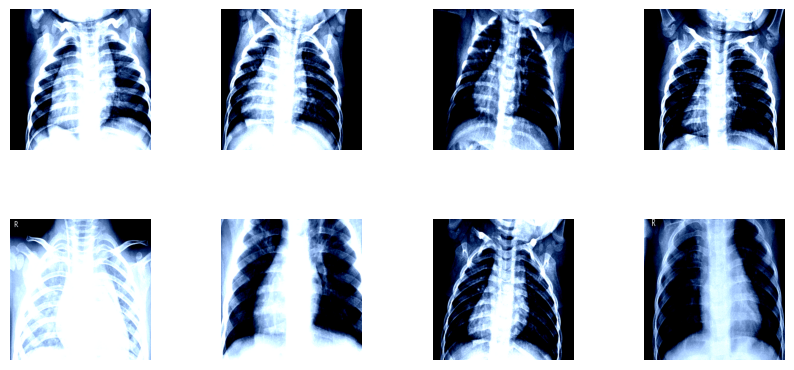

In [22]:
import cv2
def plot_images(images):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,5))
    axes = axes.ravel()
    for i in np.arange(0, len(images)):
        axes[i].imshow(images[i])
        axes[i].axis('off')
    plt.subplots_adjust(wspace=0.5)

# 8개의 학습train 배치 이미지를 시각화 
x, y = train_gen.__getitem__(0)
plot_images(x[:8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


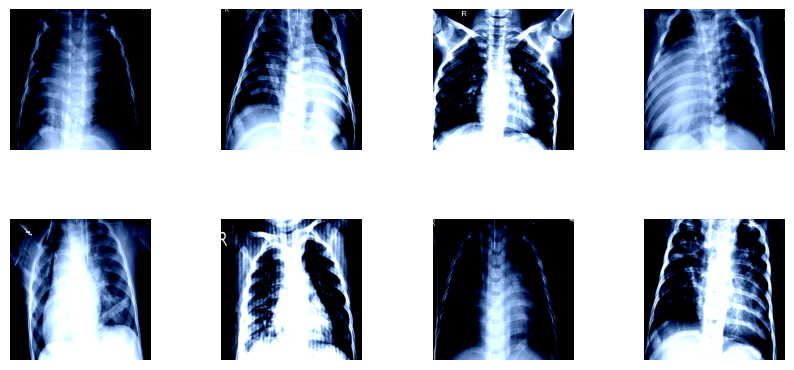

In [23]:
# 8개의 벨리데이션 배치 이미지를 시각화 
x_val, y_val = val_gen.__getitem__(0)
plot_images(x_val[:8])

### 모델 빌드 Build a model 

모델 빌드 전 고려할 사항
- 데이터가 한정적일때 딥러닝 모델 아키텍쳐를 어떻게 할 것인가 -> 심플하게 simple 
- Pretrain-model을 가져와서 transfer learning을 할때 전체를 가져올것인가 부분적으로 가져올것인가 -> 부분적으로 partially 
    - pre-trained 모델이 대규모 데이터셋에서 학습된 가중치를 사용하므로, 초기화된 가중치보다 더 좋은 초기값을 가지고 있기 때문에, Pretrain모델의 일부 레이어들의 가중치를 fine-tuning 미세조정합니다 
    - 일반적인 pre-trained모델을 살펴보면 (CNN을 예시로), 모델의 상위 레이어들은 이미지의 high-level feature(e.g. contour of object, feature)를 캡쳐하고 하위 레이어들은 low-level feature(e.g. line선 가장자리edge등의 texture feature)을 학습했습니다.
    - 때문에, 하위 레이어들에 대해서는 가중치를 동결freeze하고, 상위 레이어들을 task-specific한 feature 특징들을 학습하도록 미세조정 fine-tuning 하는것이 좋습니다. (참고로, 상위 레이어들의 high-level feature가 이미지 분류 및 객체 감지 task에서 중요합니다) 
    <br>
    


    - task 목표가 폐렴을 감지하는 것으로, 상위 레이어들 미세 조정 fine tuning 하여 램던하게 초기화된 가중치보다 좋은 결과를 
    - 일반적으로 fine-tuning시 Pre-trained 된 모델들의 레이어 가중치를 미세 조정하면, 랜덤하게 초기화된 가중치보다 훨씬 좋은 결과를 얻을 수 있습니다. 때문에 

사용할 pre-trained model
 - VGG
 - ResNet
 - Inception
 - EfficientNet 

In [24]:
import time 
import datetime # ref: https://bio-info.tistory.com/143
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

- early stopping 을 통해 지표가 개선 안되는 학습과정에서 불필요한 연산 시간을 절약할 수 있으며, 최적의 모델을 얻을 수 있습니다.
- 아래에서는 early stopping의 지표로 벨리데이션 정확도를 지정하고 ``monitor=validation_loss``, mode는 최대로 두었습니다. ``mode=max``. 
- patience를 5로하여 5epoch동안 지표가 개선 안되면 학습을 중단하고 최적모델 가중치를 복원하도록 설정하였습니다

In [25]:
# ImageNet으로 pre-trained된 VGG16 모델 불러오기
pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 모델 미세 조정
for layer in pretrained_model.layers:
    layer.trainable = False

x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

model1 = tf.keras.models.Model(pretrained_model.input, output)

opt1 = Adam(lr=1e-5)
model1.compile(loss='binary_crossentropy',
              optimizer=opt1,
              metrics=['accuracy'])

# early stopping의 지표로 벨리데이션 정확도를 선택 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = "saved_model/xray_model_1.h5" 

checkpoint_callback = ModelCheckpoint(
    # 학습중 벨리데이션 정확도가 증가시, 파일경로에 모델의 가중치를 저장
    filepath=checkpoint_filepath,
    # 모니터 부분에 지표로 벨리데이션 정확도를 명시, 모드 부분은 지표를 최대 지정하여 최고의 정확도인지를 모니터링 
    monitor='val_accuracy',
    mode='max',
    # 최고버전의 모델의 가중치만 저장함을 보장
    save_best_only=True
)

# 모델 학습 전 현재 시간 기록
start_time = time.time()

vgg_history = model1.fit(train_gen,
          epochs=20,
          validation_data=val_gen,
          callbacks=[early_stop])

# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 102s 674ms/step - loss: 0.6287 - accuracy: 0.6800 - val_loss: 0.5723 - val_accuracy: 0.7354
Epoch 2/20
131/131 [==============================] - 74s 565ms/step - loss: 0.5830 - accuracy: 0.7250 - val_loss: 0.5557 - val_accuracy: 0.7354
Epoch 3/20
131/131 [==============================] - 75s 570ms/step - loss: 0.5617 - accuracy: 0.7393 - val_loss: 0.5401 - val_accuracy: 0.7354
Epoch 4/20
131/131 [==============================] - 76s 580ms/step - loss: 0.5505 - accuracy: 0.7448 - val_loss: 0.5244 - val_accuracy: 0.7354
Epoch 5/20
131/131 [==============================] - 76s 576ms/step - loss: 0.5297 - accuracy: 0.7517 - val_loss: 0.5108 - val_accuracy: 0.7354
Epoch 6/20
131/131 [==============================] - 75s 573ms/step - loss: 0.5222 - accuracy: 0.7479 - val_loss: 0.4958 - val_accuracy: 0.7354
Epoch 7/20
131/131 [==============================] - 76s 579ms/step - loss: 0.5034 - accuracy: 0.7548 - val_loss: 0.4826 - val_a

In [28]:
tf.keras.utils.plot_model(
    model1, to_file='model1.png', show_layer_names=True, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


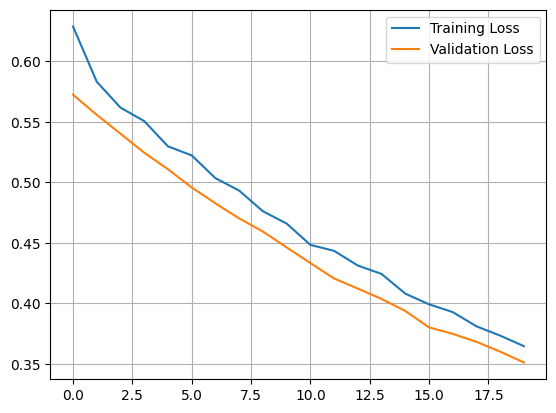

In [30]:
vgg_train_loss = vgg_history.history['loss']
vgg_val_loss = vgg_history.history['val_loss']

plt.plot(vgg_history.epoch, vgg_train_loss, label='Training Loss')
plt.plot(vgg_history.epoch, vgg_val_loss, label='Validation Loss')
plt.grid(True)
plt.legend()

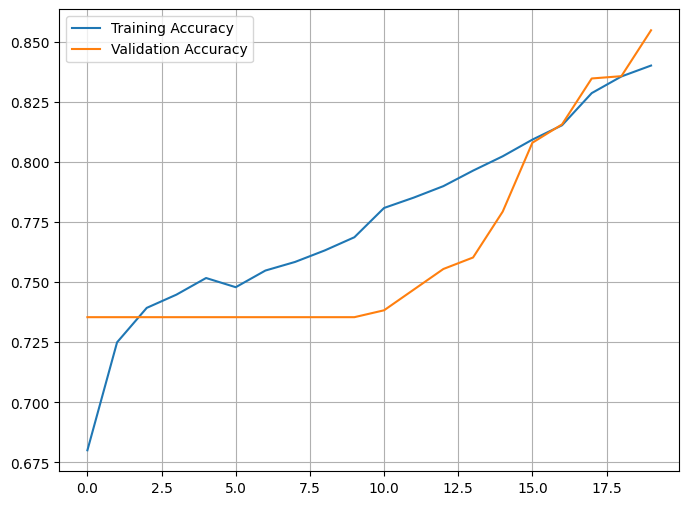

In [33]:
vgg_train_acc = vgg_history.history['accuracy']
vgg_val_acc = vgg_history.history['val_accuracy']


plt.figure(figsize=(8,6))
plt.plot(vgg_history.epoch, vgg_train_acc, label='Training Accuracy')
plt.plot(vgg_history.epoch, vgg_val_acc, label='Validation Accuracy')
plt.grid(True)
plt.legend()

In [29]:
# VGG16 모델 평가
vgg_test_loss, vgg_test_acccuracy = model1.evaluate(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(vgg_test_loss, vgg_test_acccuracy))

20/20 [==============================] - 14s 694ms/step - loss: 0.5328 - accuracy: 0.6587
Test loss is: 0.532760739326477, Test Accuracy is: 0.6586538553237915


In [35]:
model1.save('saved_model/xray_model_1.h5')
model1 = load_model('saved_model/xray_model_1.h5')

- 베이스 모델로 pretrained resnet50을 넣어주고, input 사이즈를 224,224,3로 지정하였습니다. 
- 때문에 data augmentation에서 Resize부분을 A.Resize(256,256)로 바꿔주고, 이미지를 랜덤으로 크롭하는 부분을 A.RandomCrop(224, 224)로 바꾸어 준 뒤에 모델 학습을 진행했습니다

In [36]:
from tensorflow.keras.applications import ResNet50

# ImageNet으로 pre-trained된 ResNet50 모델 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224, 3))

# 모델 구조 출력
base_model.summary()

# 파라미터 설정
batch_size = 32

# 새로운 fully connected layer 추가
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(units=1, activation='softmax')(x)

# 새로운 모델 생성
model2 = tf.keras.models.Model(inputs=base_model.input, outputs=output)

# 모델 구조 출력
model2.summary()


# ResNet18 모델의 첫 100개 layer들은 fine-tuning미세조정에서 고정시킴
for layer in model2.layers[:100]:
    layer.trainable = False
    
# fine-tuning 시 optimizer, loss function, metric 등 설정
opt2 = Adam(lr=0.0001)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [38]:
# ModelCheckpoint 콜백(callback) 정의
checkpoint_filepath = 'saved_model/xray_model_3_resnet.h5' 
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# 모델 학습 전 현재 시간 기록
start_time = time.time()

# 모델 학습
res_history = model2.fit(train_gen,
                         epochs=20,
                         validation_data=val_gen,
                         callbacks=[early_stop])


# 모델 학습 후 현재 시간 기록
end_time = time.time()

# 걸린 시간 계산
elapsed_time = end_time - start_time

# 시간 출력
print(f"Elapsed Time: {datetime.timedelta(seconds=elapsed_time)}")

Epoch 1/20
131/131 [==============================] - 87s 622ms/step - loss: 0.2391 - accuracy: 0.7438 - val_loss: 4.7917 - val_accuracy: 0.7354
Epoch 2/20
131/131 [==============================] - 78s 589ms/step - loss: 0.1489 - accuracy: 0.7438 - val_loss: 0.3826 - val_accuracy: 0.7354
Epoch 3/20
131/131 [==============================] - 77s 584ms/step - loss: 0.1490 - accuracy: 0.7438 - val_loss: 0.3076 - val_accuracy: 0.7354
Epoch 4/20
131/131 [==============================] - 76s 575ms/step - loss: 0.1323 - accuracy: 0.7438 - val_loss: 2.3116 - val_accuracy: 0.7354
Epoch 5/20
131/131 [==============================] - 76s 576ms/step - loss: 0.1045 - accuracy: 0.7438 - val_loss: 0.6906 - val_accuracy: 0.7354
Epoch 6/20
131/131 [==============================] - 76s 577ms/step - loss: 0.1099 - accuracy: 0.7438 - val_loss: 0.3159 - val_accuracy: 0.7354
Epoch 7/20
131/131 [==============================] - 77s 589ms/step - loss: 0.0985 - accuracy: 0.7438 - val_loss: 3.8302 - val_ac

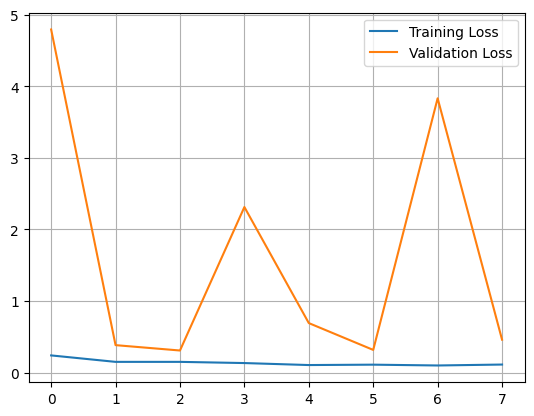

In [39]:
res_train_loss = res_history.history['loss']
res_val_loss = res_history.history['val_loss']

plt.plot(res_history.epoch, res_train_loss, label='Training Loss')
plt.plot(res_history.epoch, res_val_loss, label='Validation Loss')
plt.grid(True)
plt.legend()

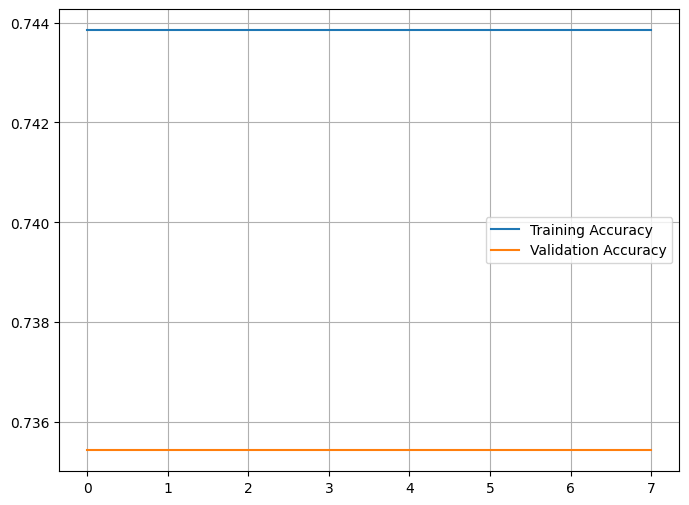

In [42]:
res_train_acc = res_history.history['accuracy']
res_val_acc = res_history.history['val_accuracy']


plt.figure(figsize=(8,6))
plt.plot(res_history.epoch, res_train_acc, label='Training Accuracy')
plt.plot(res_history.epoch, res_val_acc, label='Validation Accuracy')
plt.grid(True)
plt.legend()

In [41]:
# resnet50 모델 평가1
res_test_loss, res_test_acccuracy = model2.evaluate(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(res_test_loss, res_test_acccuracy))

model2.save(checkpoint_filepath)

20/20 [==============================] - 10s 480ms/step - loss: 3.6415 - accuracy: 0.6250
Test loss is: 3.6415083408355713, Test Accuracy is: 0.625


Second Try
- Pretrained resnet50의 evaultaion accuracy가 62.5% 로 나왔습니다. 


In [ ]:
# resnet50 모델 평가2
res_test_loss, res_test_acccuracy = model2.evaluate(test_gen)
print("Test loss is: {}, Test Accuracy is: {}".format(res_test_loss, res_test_acccuracy))

In [ ]:
# 최상 모델을 불러오기 
model2.save(checkpoint_filepath)
model2 = load_model(checkpoint_filepath)
